<a href="https://colab.research.google.com/github/doudi25/Triton/blob/main/Diffusion_Forward_Process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import torch
from torch import nn
import triton
import triton.language as tl
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [22]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)
dataloader = DataLoader(mnist_dataset, batch_size=32, shuffle=True)


In [26]:
@triton.jit
def forward_process_kernel(img_ptr,noise_ptr,noisy_ptr,ap_ptr,stride_ib,stride_ic,stride_im,
                           bs,c,h,w,BLOCK_SIZE_ROW:tl.constexpr,BLOCK_SIZE_COL:tl.constexpr,num_warps=8):
  batch_id = tl.program_id(axis=0)
  channel_id = tl.program_id(axis=1)
  pid_3 = tl.program_id(axis=2)
  num_pid_n = tl.cdiv(w,BLOCK_SIZE_COL)
  pid_row = pid_3 // num_pid_n
  pid_col = pid_3 %  num_pid_n
  offs_row = pid_row * BLOCK_SIZE_ROW + tl.arange(0,BLOCK_SIZE_ROW)
  offs_col = pid_col * BLOCK_SIZE_COL + tl.arange(0,BLOCK_SIZE_COL)
  mask = (offs_row[:,None] < h) & (offs_col[None,:] < w)
  img_ptrs = img_ptr + batch_id * stride_ib + channel_id * stride_ic + offs_row[:,None] * stride_im + offs_col[None,:]
  noise_ptrs = noise_ptr + batch_id * stride_ib + channel_id * stride_ic + offs_row[:,None] * stride_im + offs_col[None,:]
  img_chunk = tl.load(img_ptrs,mask=mask,other=0.0)
  noise_chunk = tl.load(noise_ptrs,mask=mask,other=0.0)
  alphaprod = tl.load(ap_ptr)
  noisy = img_chunk * tl.sqrt(alphaprod) + tl.sqrt(1-alphaprod) * noise_chunk
  noisy_ptrs = noisy_ptr + batch_id * stride_ib + channel_id * stride_ic + offs_row[:,None] * stride_im + offs_col[None,:]
  tl.store(noisy_ptrs,noisy,mask=mask)


In [27]:
def forward_process(image:torch.tensor,t:int):
  beta = torch.linspace(1e-4,0.02,1000).to('cuda')
  alpha = 1-beta
  alphaprod = torch.cumprod(alpha,dim=0)
  bs,c,h,w = image.shape
  noisy_image = torch.empty_like(image,device=image.device,dtype=image.dtype)
  noise = torch.randn_like(image)
  BLOCK_SIZE_ROW = 16
  BLOCK_SIZE_COL = 16
  grid = (bs,c,(triton.cdiv(h,BLOCK_SIZE_ROW)*triton.cdiv(w,BLOCK_SIZE_COL)))
  forward_process_kernel[grid](image,noise,noisy_image,alphaprod[t],image.stride(0),image.stride(1),image.stride(2),
                               bs,c,h,w,BLOCK_SIZE_ROW,BLOCK_SIZE_COL)
  return noisy_image



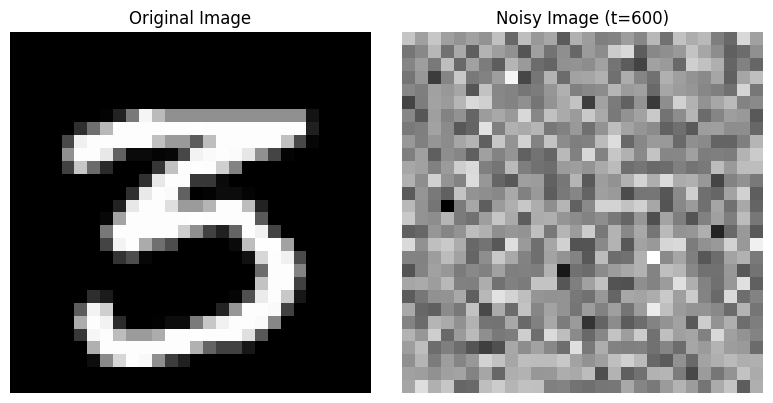

In [28]:
images, _ = next(iter(dataloader))  # Get the first batch, ignore labels
images = images.to('cuda')

noisy_images = forward_process(images, 600)  # Generate noisy version

images = images.cpu() * 0.5 + 0.5  # Denormalize: reverse (0.5, 0.5) normalization
noisy_images = noisy_images.cpu() * 0.5 + 0.5  # Denormalize noisy images

plt.figure(figsize=(8, 4))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(images[0].squeeze(), cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Noisy image
plt.subplot(1, 2, 2)
plt.imshow(noisy_images[0].squeeze(), cmap='gray')
plt.title("Noisy Image (t=600)")
plt.axis('off')

plt.tight_layout()
plt.show()